In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, Lasso, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import t_sne

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import lightgbm as lgb

from xgboost import XGBClassifier, XGBRegressor

from scipy import stats
from scipy.special import boxcox1p

%matplotlib inline

In [43]:
trainCsvFilepath = r'../input/forest-cover-type-prediction/train.csv'
train = pd.read_csv(trainCsvFilepath)

testCsvFilepath = r'../input/forest-cover-type-prediction/test.csv'
test = pd.read_csv(testCsvFilepath)

In [4]:
merged = pd.concat([train, test], sort=False, axis=0)

In [20]:
merged.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   
2            234             238            135  ...            0   
3            238             238            122  ...            0   
4            220             234            150  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0         5.0  
1            0            0            0         5.0  
2            0            0            0         2.0  
3            0            0            0         2.0  
4            0            0            0         5.0  

[5 rows x 56 columns]

In [23]:
merged.Cover_Type.value_counts()

7.0    2160
6.0    2160
5.0    2160
4.0    2160
1.0    2160
3.0    2160
2.0    2160
Name: Cover_Type, dtype: int64

In [6]:
merged.shape

(581012, 56)

# PCA plot

In [41]:
pca.explained_variance_ratio_

array([0.08040058, 0.0582986 , 0.04735081, 0.03944626, 0.02981452,
       0.02668024, 0.02193227, 0.02150013, 0.0211616 , 0.02042854,
       0.01986748, 0.01983605, 0.01967561, 0.01957332, 0.01948057,
       0.01934191, 0.01933803, 0.01922215, 0.01918556, 0.01914665])

C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


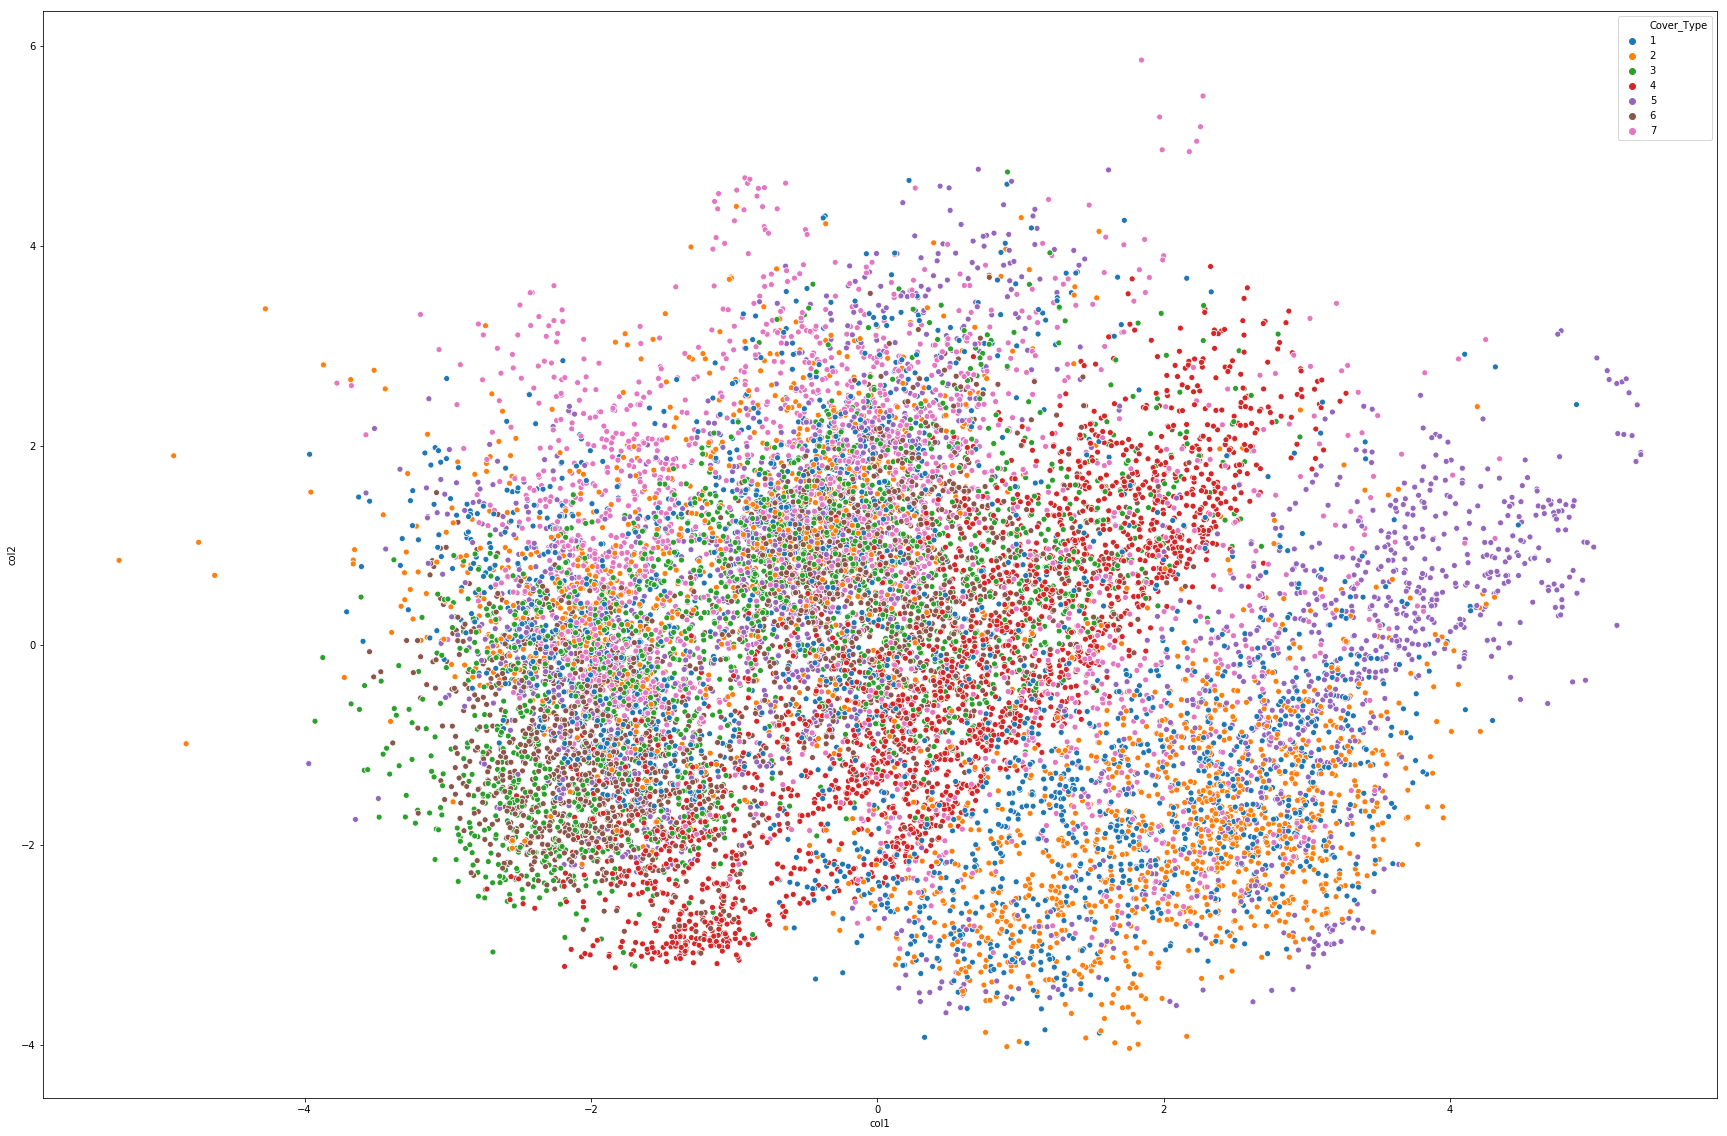

In [44]:
pca = PCA(n_components=20)
scaledData = StandardScaler().fit_transform(train.drop(columns=['Cover_Type']))
pca_data = pca.fit_transform(scaledData)
pca_df = pd.DataFrame(columns=['col' + str(x) for x in range(0, 20)], data=pca_data)

plt.figure(figsize=(30, 20))
sns.scatterplot(x=pca_df.col1, y=pca_df.col2, hue=train.Cover_Type, palette=sns.color_palette()[:7], )

## t-SNE

C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3x64\envs\ml\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


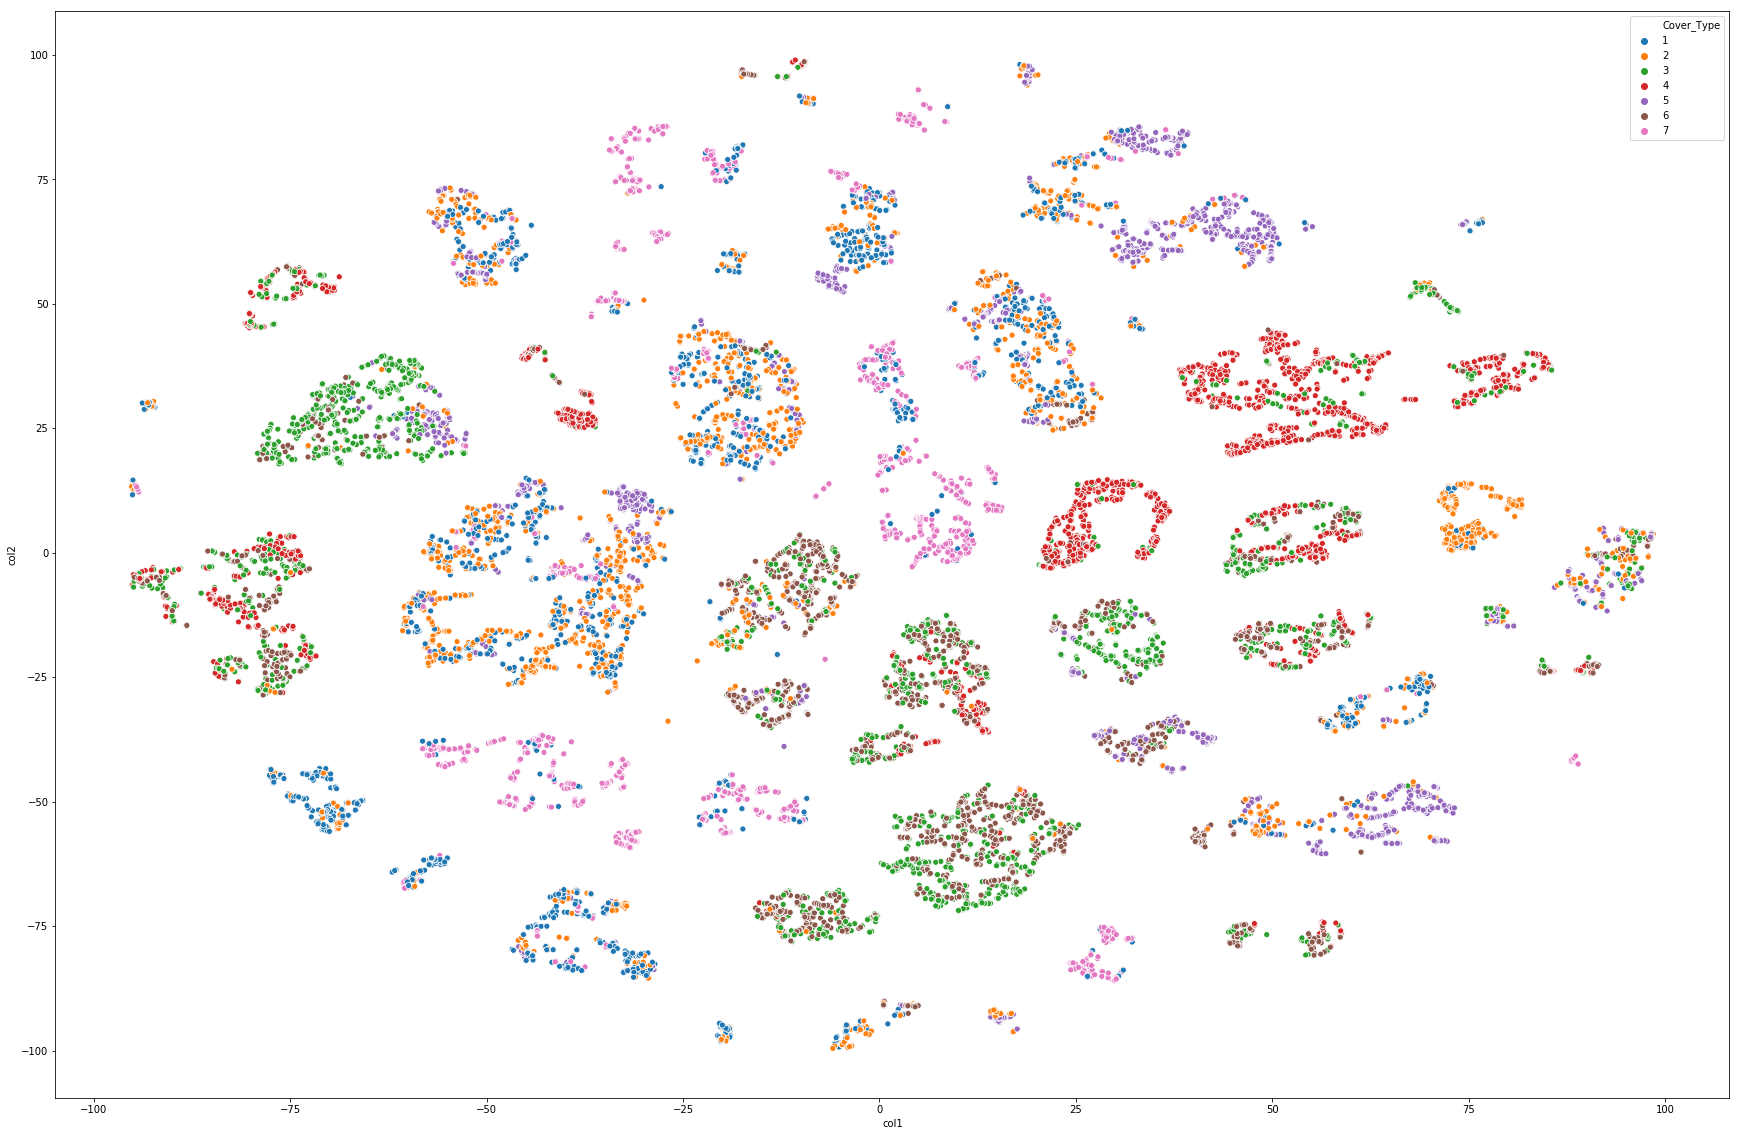

In [46]:
tsne = t_sne.TSNE(n_components=2)
scaledData = StandardScaler().fit_transform(train.drop(columns=['Cover_Type']))
tsne_data = tsne.fit_transform(scaledData)
tsne_df = pd.DataFrame(columns=['col1', 'col2'], data=tsne_data)

plt.figure(figsize=(30, 20))
sns.scatterplot(x=tsne_df.col1, y=tsne_df.col2, hue=train.Cover_Type, palette=sns.color_palette()[:7], )

In [7]:
isnull = pd.isna(merged).sum()
print(isnull[isnull > 0].sort_values())
print()

isnullObjs = pd.isnull(merged.select_dtypes(include=['object'])).sum()
print(isnullObjs[isnullObjs > 0].sort_values())
print()

isnullNonObjs = pd.isnull(merged.select_dtypes(exclude=['object'])).sum()
print(isnullNonObjs[isnullNonObjs > 0].sort_values())

Cover_Type    565892
dtype: int64

Series([], dtype: float64)

Cover_Type    565892
dtype: int64


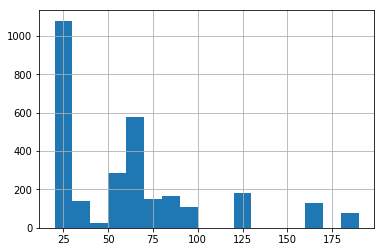

In [8]:
merged.MSSubClass.hist(bins=np.arange(merged.MSSubClass.unique().min(), merged.MSSubClass.unique().max() + 10, 10))

In [8]:
objectView = merged.select_dtypes(include=['object'])
print(objectView.shape[1])
for column in objectView.columns:
    print(column)
    print(merged[column].value_counts())
    print('__________________________________________')

0


In [26]:
merged.MiscFeature[pd.notnull(merged.MiscFeature)].value_counts()

Shed    95
Gar2     5
Othr     4
TenC     1
Name: MiscFeature, dtype: int64

In [32]:
merged.select_dtypes(exclude=['object']).dtypes.value_counts()

int64      26
float64    12
dtype: int64

In [33]:
merged.select_dtypes(exclude=['object']).dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
dtype: object

In [39]:
merged.LotFrontage.value_counts()

60.0     276
80.0     137
70.0     133
50.0     117
75.0     105
65.0      93
85.0      76
21.0      50
24.0      49
63.0      47
78.0      46
90.0      46
68.0      44
64.0      43
74.0      39
72.0      39
73.0      33
62.0      31
52.0      28
100.0     28
82.0      28
79.0      28
51.0      27
59.0      27
57.0      26
66.0      26
76.0      25
53.0      24
55.0      24
43.0      23
        ... 
140.0      2
122.0      2
116.0      2
149.0      2
150.0      2
174.0      2
25.0       1
123.0      1
135.0      1
111.0      1
117.0      1
131.0      1
200.0      1
22.0       1
136.0      1
28.0       1
31.0       1
133.0      1
155.0      1
153.0      1
126.0      1
152.0      1
168.0      1
144.0      1
138.0      1
137.0      1
182.0      1
119.0      1
195.0      1
141.0      1
Name: LotFrontage, Length: 128, dtype: int64

In [38]:
merged.loc[pd.isna(merged.FireplaceQu)].Fireplaces.sum()

0

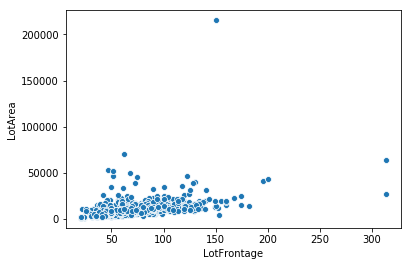

In [41]:
lotAndFrontage=merged.loc[pd.notnull(merged.LotFrontage)]
sns.scatterplot(data=lotAndFrontage, x='LotFrontage', y='LotArea')

In [52]:
garageFeatures = [x for x in list(merged.select_dtypes(include=['object']).columns) if 'Garage' in x]

print(merged.loc[:, garageFeatures].dropna(axis=0, how='all').shape)
print(merged.loc[:, garageFeatures].dropna(axis=0, how='any').shape)

print(merged.shape[0])
print(pd.isna(merged.GarageCond).sum())

(2762, 4)
(2760, 4)
2919
159


In [57]:
bsmtFeatures = [x for x in list(merged.select_dtypes(include=['object']).columns) if 'Bsmt' in x]

print(merged.loc[:, bsmtFeatures].dropna(axis=0, how='all').shape)
print(merged.loc[:, bsmtFeatures].dropna(axis=0, how='any').shape)

print(merged.shape[0])
print(pd.isna(merged.BsmtQual).sum())

(2840, 5)
(2831, 5)
2919
81


['MasVnrType', 'MasVnrArea']
(2896, 2)
(2895, 2)


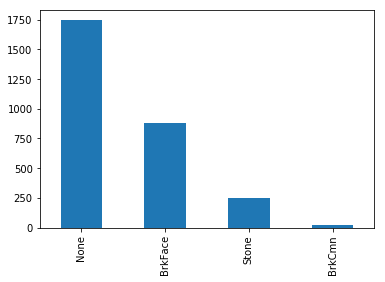

In [64]:
    

masFeatures = [x for x in list(merged.columns) if 'Mas' in x]
print(masFeatures)

print(merged.loc[:, masFeatures].dropna(axis=0, how='all').shape)
print(merged.loc[:, masFeatures].dropna(axis=0, how='any').shape)

merged.MasVnrType.value_counts().plot(kind='bar')

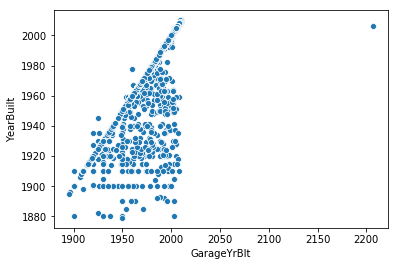

In [83]:
yrb = merged.loc[pd.notnull(merged.GarageYrBlt) & pd.notnull(merged.YearBuilt)]
sns.scatterplot(x=yrb.GarageYrBlt, y=yrb.YearBuilt)

In [133]:
def customFillna(X:pd.DataFrame):
    X = X.copy()
    # pool
    X['HasPool'] = X.PoolArea.apply(lambda x: int(x > 0))
    X.PoolQC.fillna(value='NA', inplace=True)
    #X.drop(columns=['PoolQC', 'PoolArea'], inplace=True)
    
    X.MiscFeature.fillna(value='NA', inplace=True)
    
    X.Alley.fillna(value='NA', inplace=True)
    
    X.Fence.fillna(value='NA', inplace=True)
    
    X.FireplaceQu.fillna(value='NA', inplace=True)
    
    # lot frontage
    X.LotFrontage.fillna(value=X.LotFrontage.mean(), inplace=True)
    X.drop(columns=['LotFrontage'], inplace=True)
    
    # Garage
    garageObjFeatures = [x for x in list(X.select_dtypes(include=['object']).columns) if 'Garage' in x]
    for feat in garageObjFeatures:
        X[feat].fillna(value='NA', inplace=True)
        
    # Garage year built
    X.GarageYrBlt.fillna(value=0, inplace=True)
    
    # Bsmt
    bsmtFeatures = [x for x in list(X.select_dtypes(include=['object']).columns) if 'Bsmt' in x]
    for feat in bsmtFeatures:
        X[feat].fillna(value='NA', inplace=True)
    
    # Mas
    X.MasVnrArea.fillna(value=0, inplace=True)
    X.MasVnrType.fillna(value='NA', inplace=True)
    
    # Object NA less than 10:
    isnaObjFeats = pd.isnull(X.select_dtypes(include=['object'])).sum()
    isnaObjFeats = list(isnaObjFeats[(isnaObjFeats > 0) & (isnaObjFeats < 10)].index)
    for feat in isnaObjFeats:
        X[feat].fillna(value=X[feat].mode()[0], inplace=True)
        
    # Numerical NA less than 10:
    isnaNumFeats = pd.isnull(X.select_dtypes(exclude=['object'])).sum()
    isnaNumFeats = list(isnaNumFeats[(isnaNumFeats > 0) & (isnaNumFeats < 10)].index)
    for feat in isnaNumFeats:
        X[feat].fillna(value=0, inplace=True)
    
    return X
    

In [134]:
naFilled = customFillna(merged)
na = pd.isna(naFilled).sum()
assert na[na > 0].sort_values().count() == 1

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


C:\Anaconda3x64\envs\ml\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


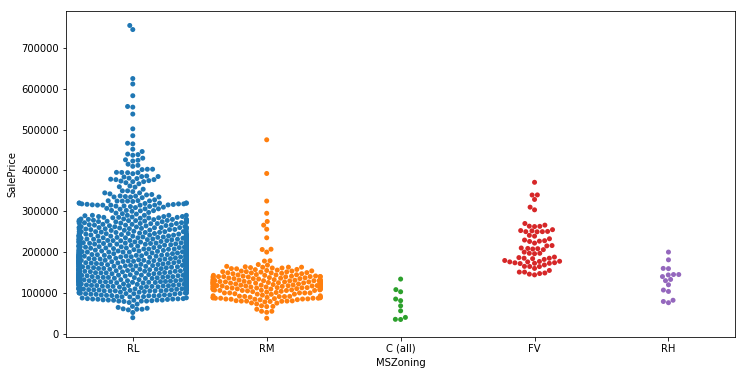

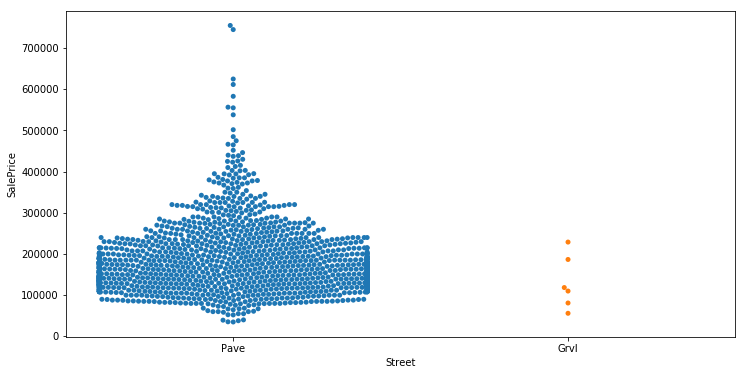

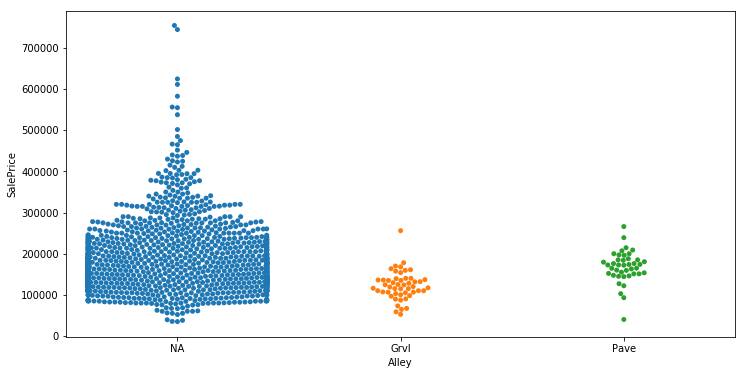

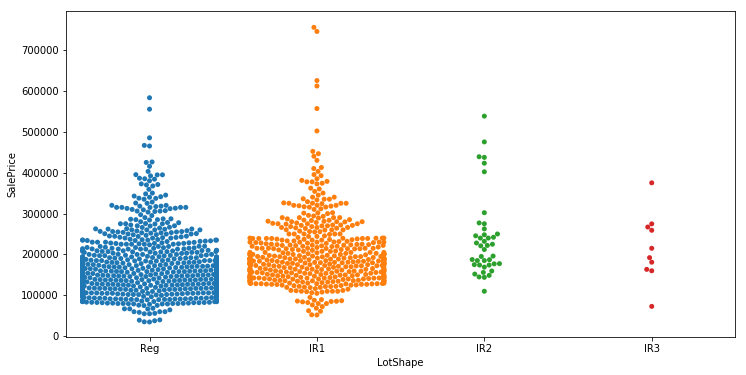

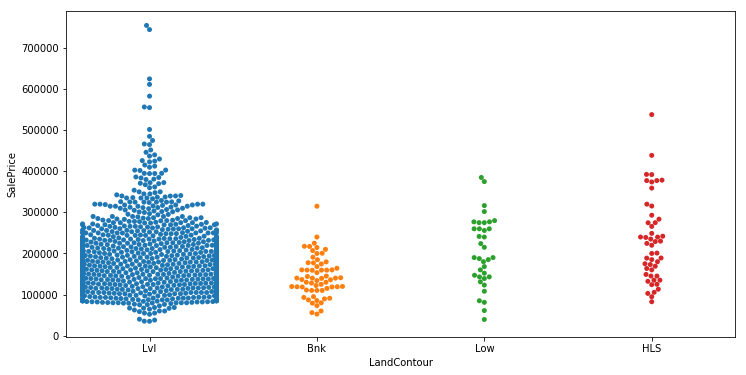

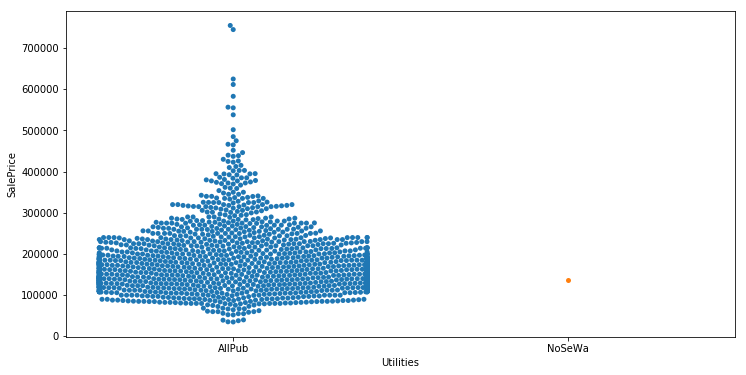

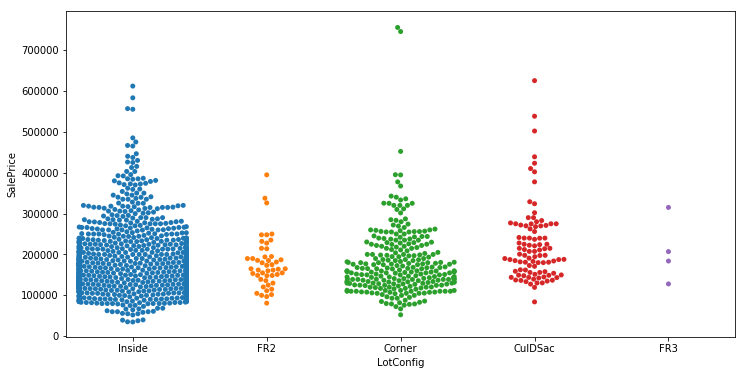

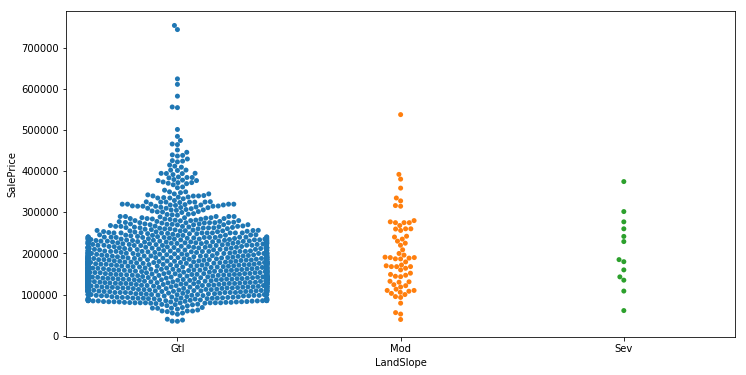

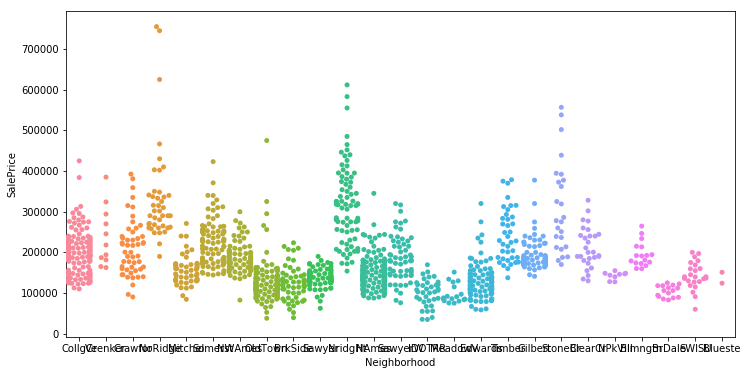

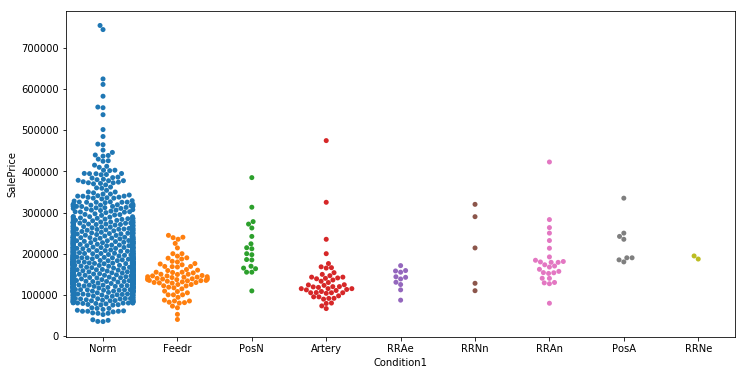

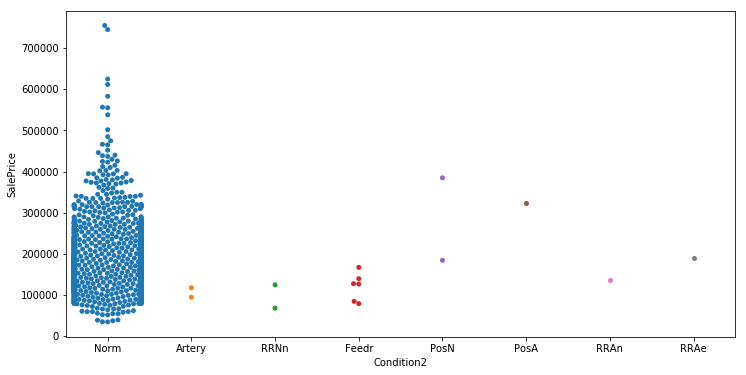

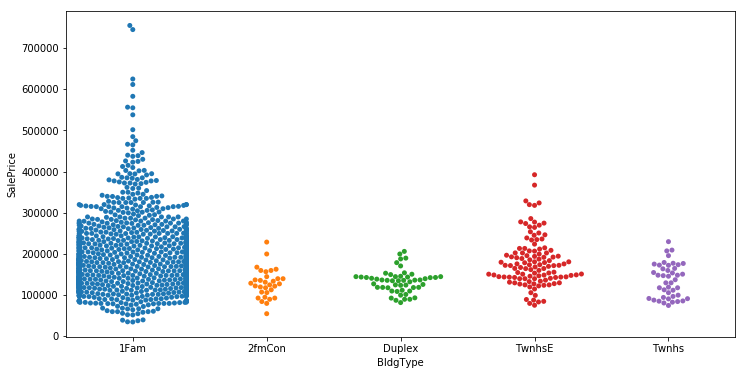

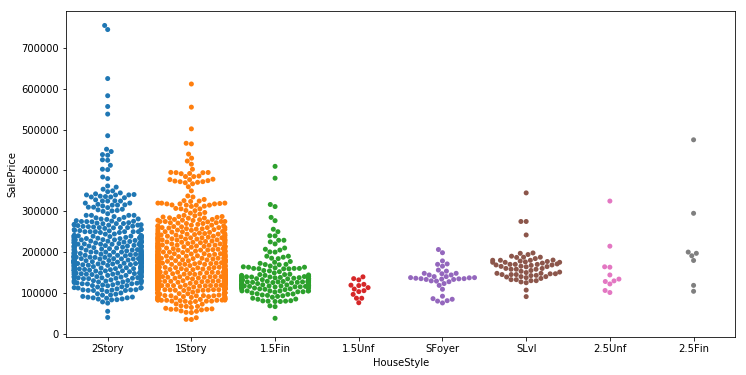

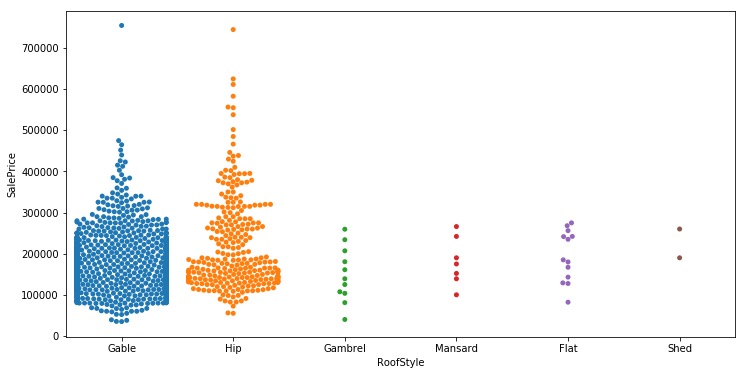

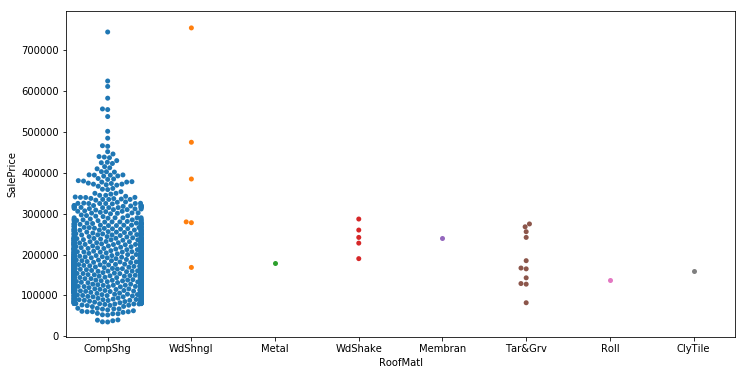

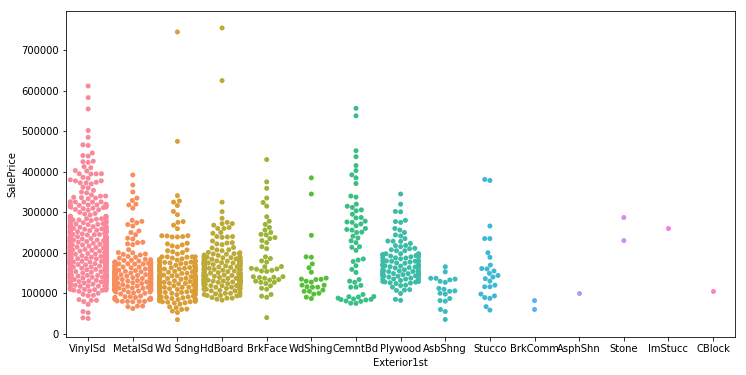

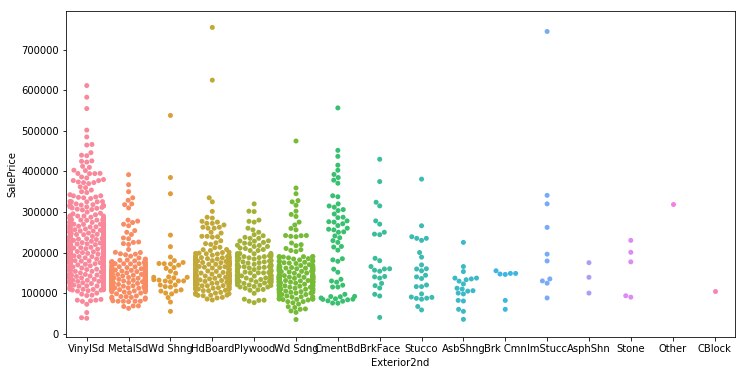

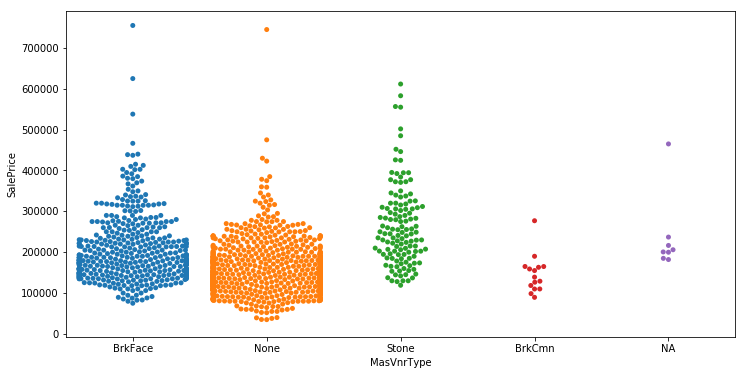

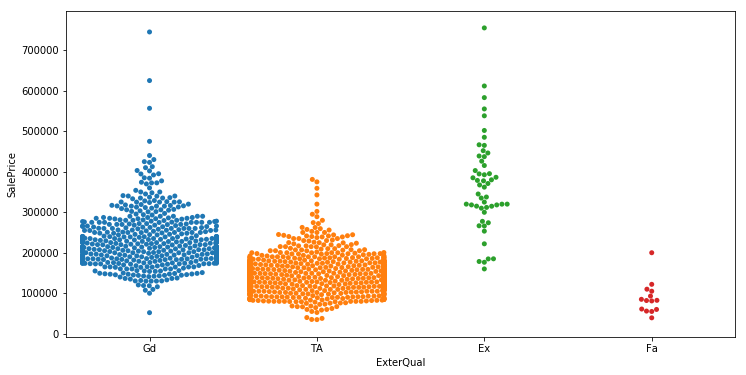

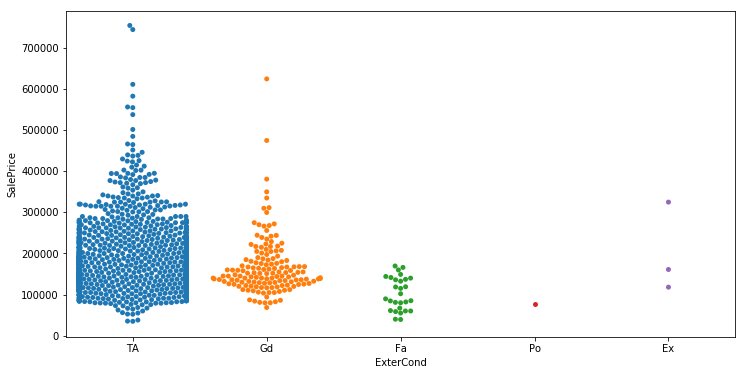

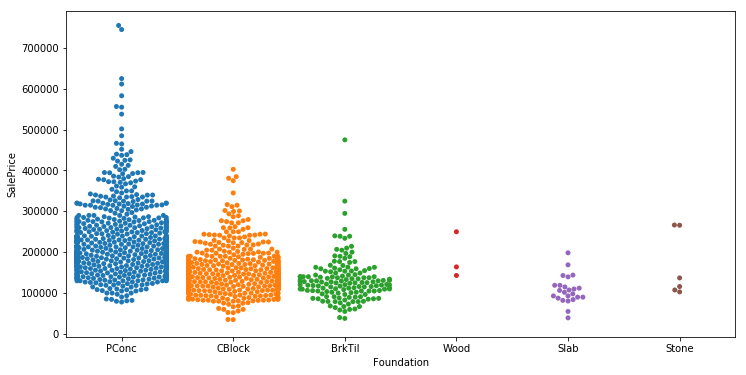

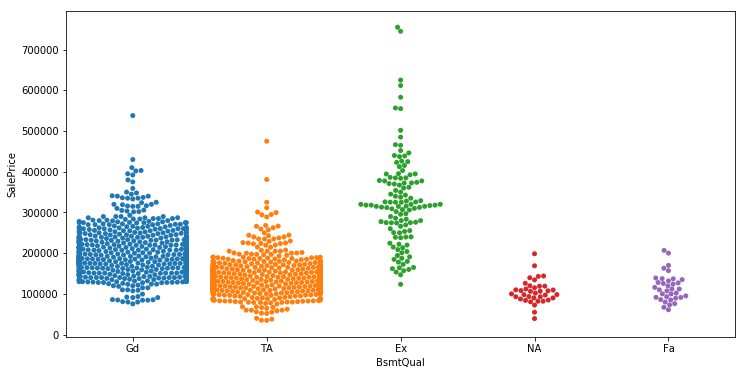

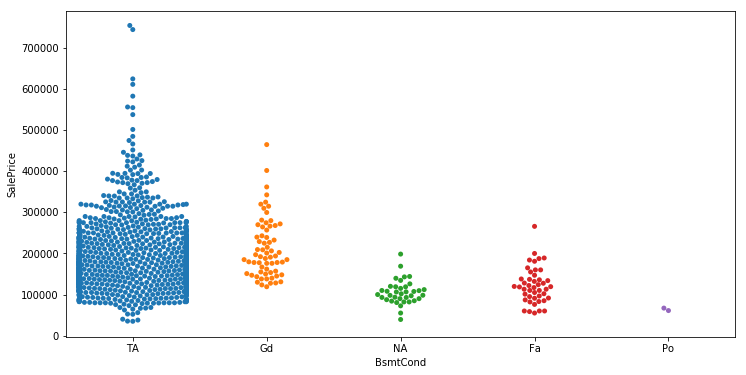

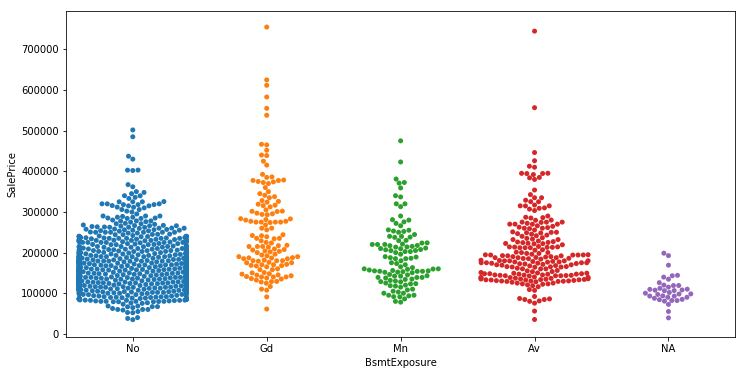

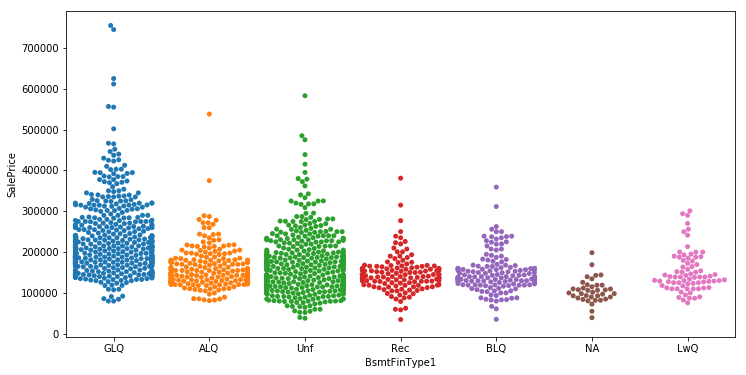

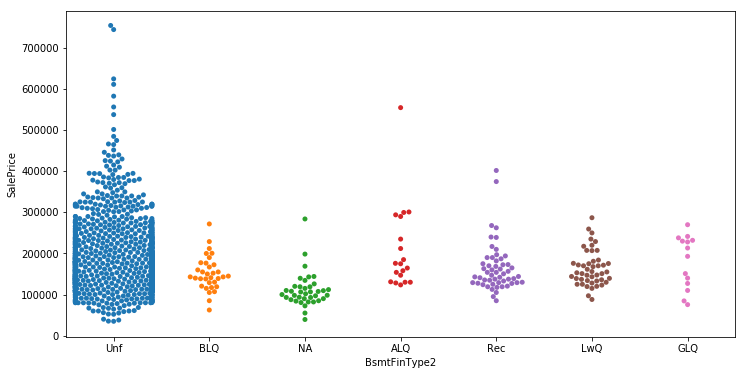

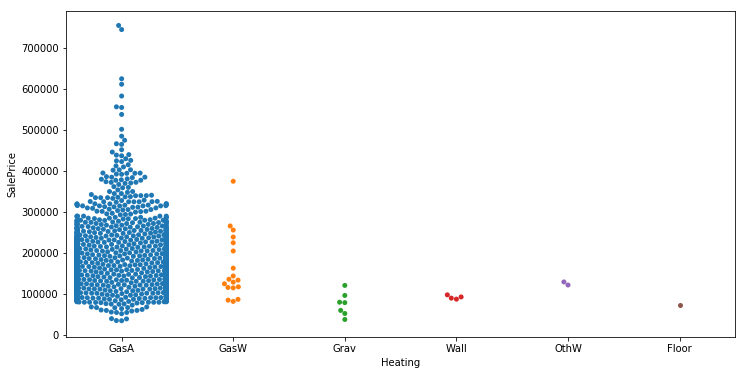

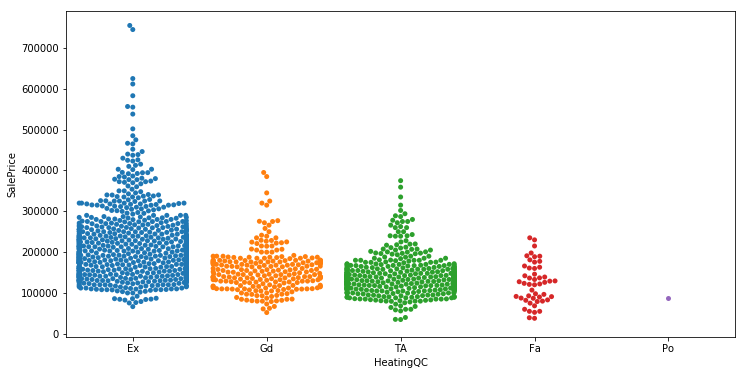

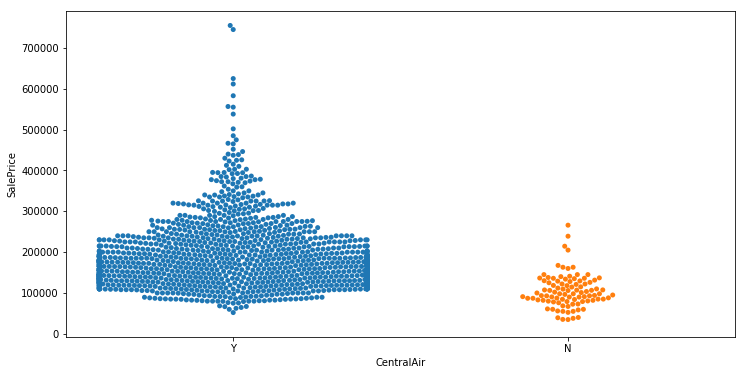

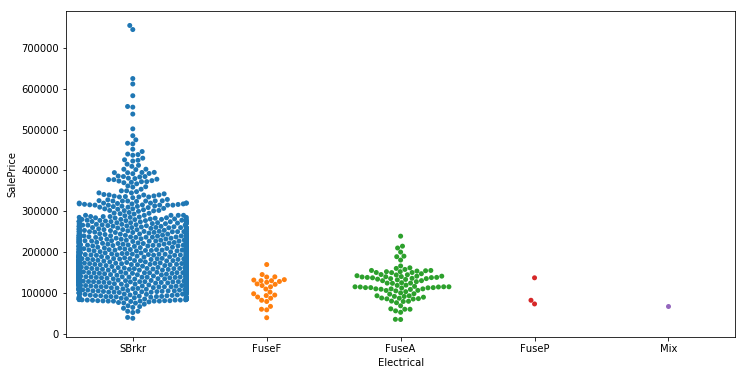

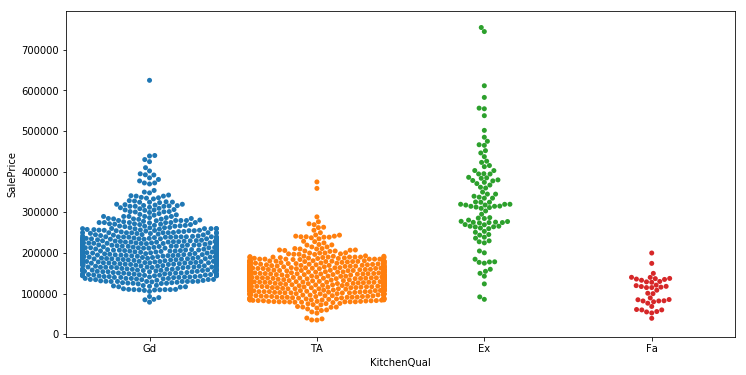

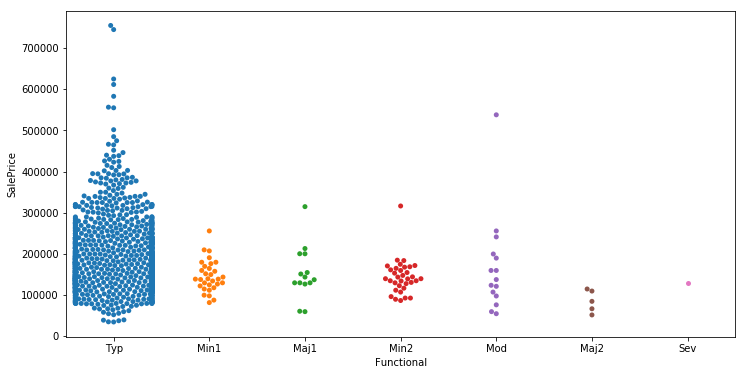

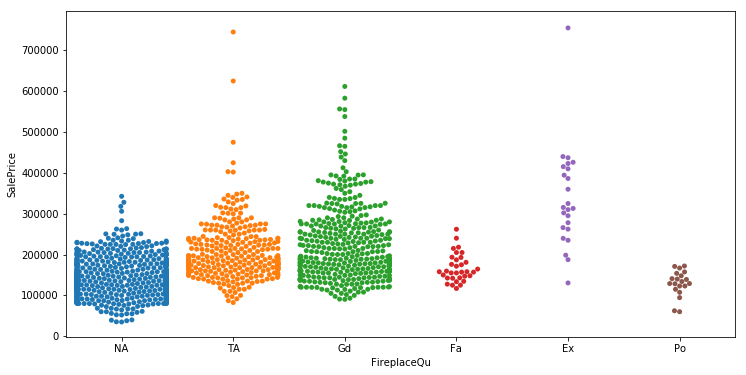

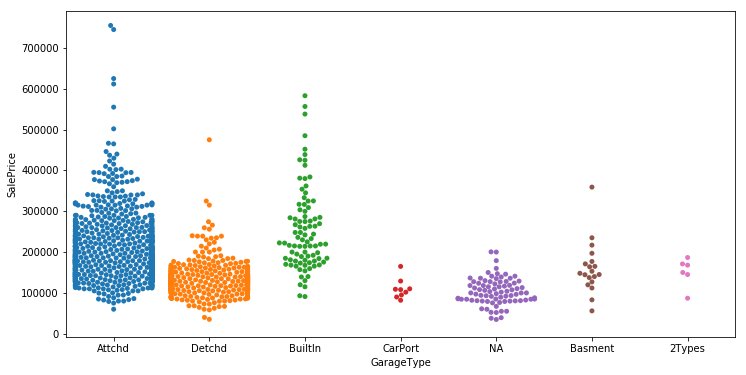

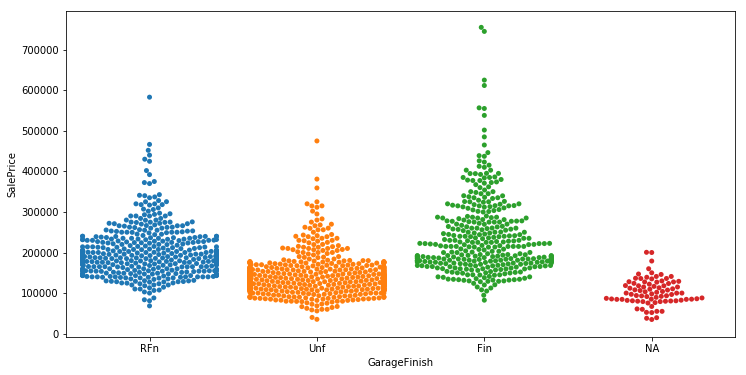

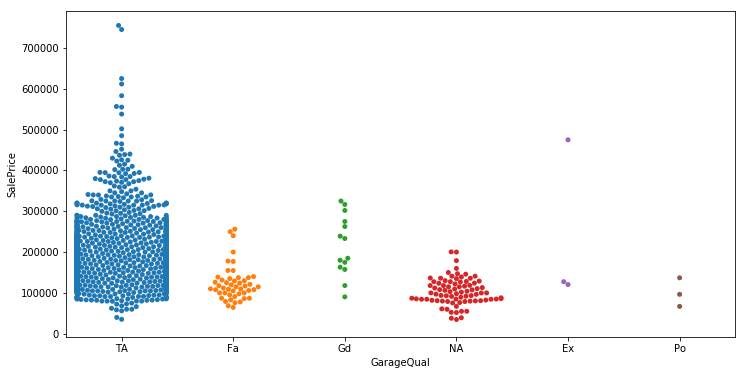

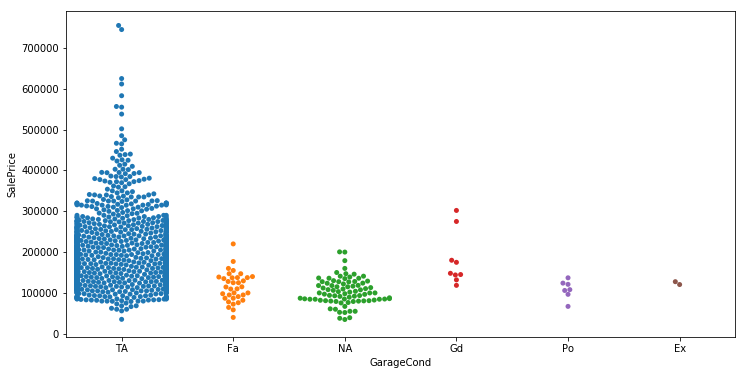

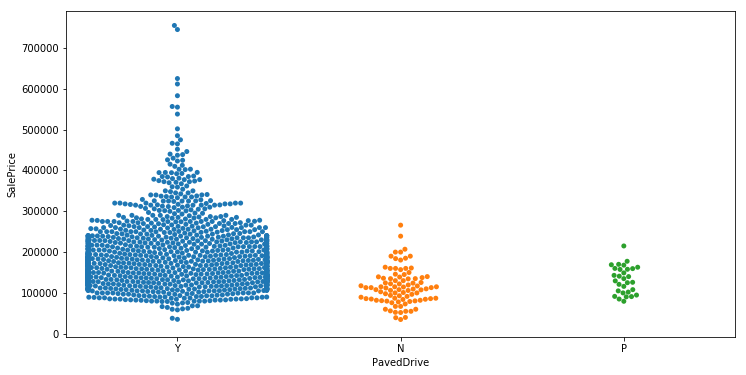

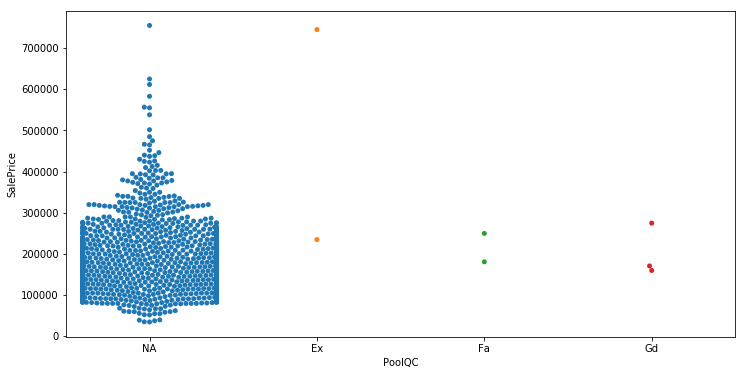

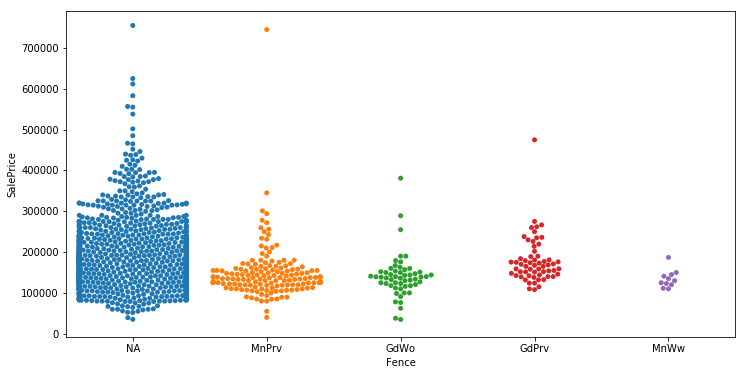

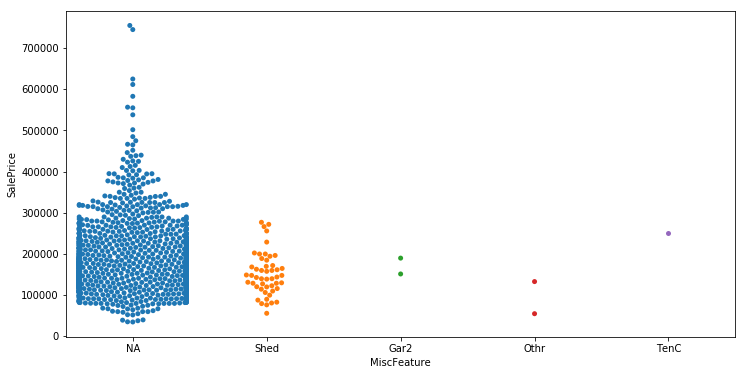

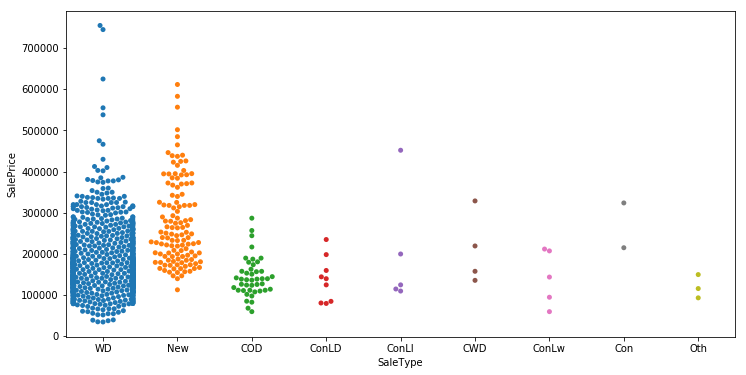

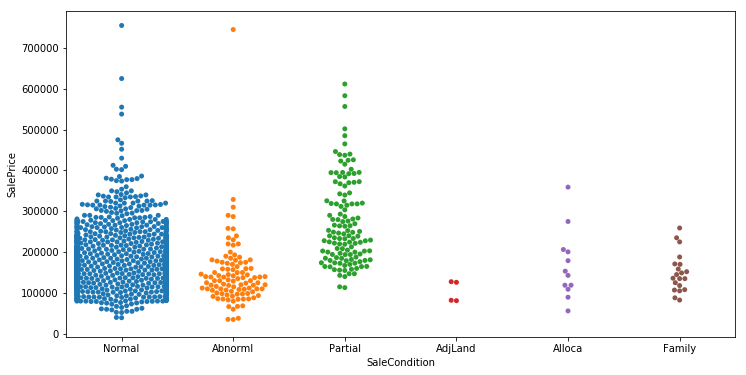

In [132]:
catFeats = list(naFilled.select_dtypes(include=['object']).columns)
print(catFeats)

for idx, feat in enumerate(catFeats):
    plt.figure(figsize=(12, 6))
    sns.swarmplot(x=naFilled[feat], y=naFilled.SalePrice)

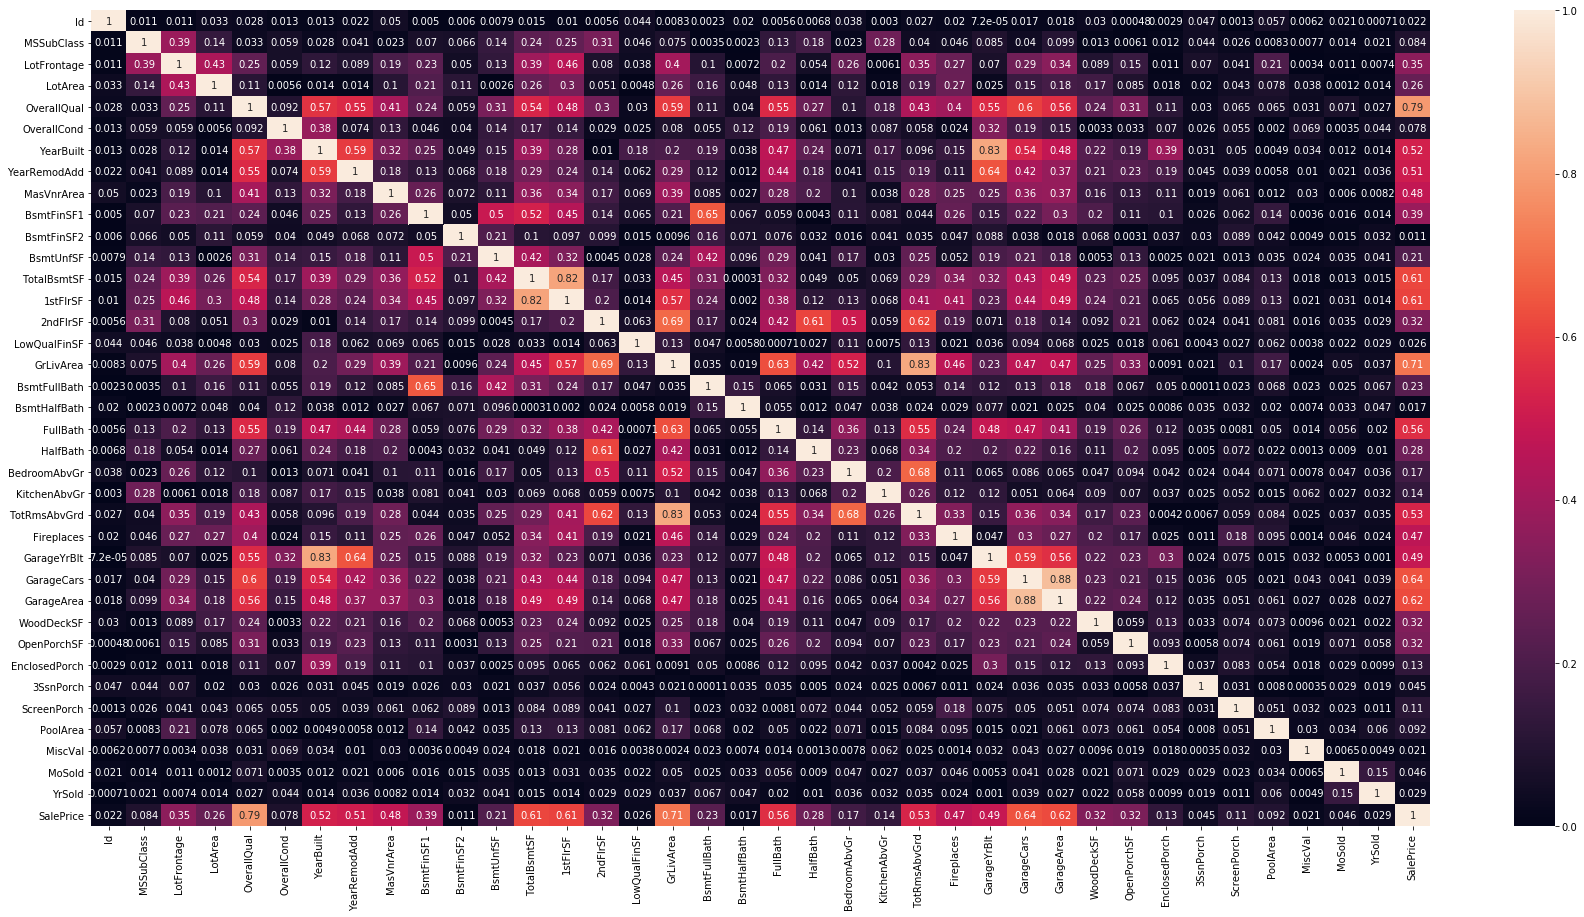

In [139]:
plt.figure(figsize=[30,15])
sns.heatmap(train.corr().abs(), annot=True)

In [148]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

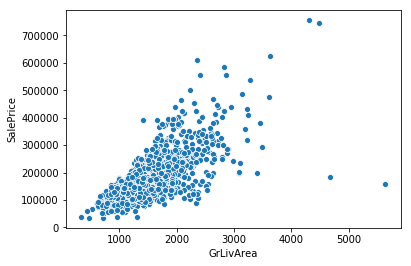

In [150]:
sns.scatterplot(x=train['GrLivArea'], y=train['SalePrice'])

array(['60', '20', '70', '50', '190', '45', '90', '120', '30', '85', '80',
       '160', '75', '180', '40', '150'], dtype=object)

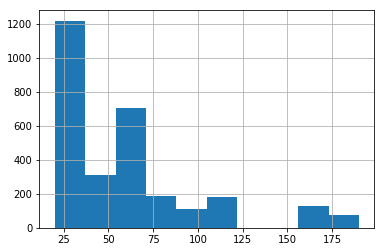

In [161]:
houses=naFilled.copy()
naFilled.MSSubClass.hist()
houses['MSSubClass']=houses['MSSubClass'].astype(str)
houses['MSSubClass'].unique()

In [162]:
from scipy.stats import skew

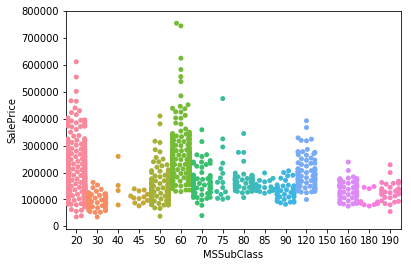

In [164]:
sns.swarmplot(x=naFilled.MSSubClass, y=naFilled.SalePrice)